In [1]:
import datetime as dt
import os
import sys
sys.path.append(os.pardir)

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

from covid_19.compartmental_models import SEIRDModel
from covid_19.utils import train_test_split

In [2]:
# data
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
recovered_cases = np.loadtxt('../data/recovered_cases.dat')
death_cases = np.loadtxt('../data/death_cases.dat')
removed_cases = recovered_cases + death_cases
active_cases = confirmed_cases - removed_cases

# 1st wave data
start_date_1 = dt.datetime(2020, 2, 26)
end_date_1 = dt.datetime(2020, 6, 5)
diff = abs((end_date_1 - start_date_1).days)

confirmed_cases_1 = confirmed_cases[:diff+1]
recovered_cases_1 = recovered_cases[:diff+1]
death_cases_1 = death_cases[:diff+1]
removed_cases_1 = removed_cases[:diff+1]
active_cases_1 = active_cases[:diff+1]

# 2nd wave data
start_date_2 = dt.datetime(2020, 6, 6)
confirmed_cases_2 = confirmed_cases[diff+1:]
recovered_cases_2 = recovered_cases[diff+1:]
death_cases_2 = death_cases[diff+1:]
removed_cases_2 = removed_cases[diff+1:] - removed_cases[diff+1]
active_cases_2 = active_cases[diff+1:]

In [3]:
def simulate_SEIRD(active_cases, recovered_cases, death_cases, initial_conditions, split_ratio, epidemics_start_date):
    """Plot SEIR forecast and return the reproduction number estimate and loss values.
    
    Parameters
    ----------
    active_cases : numpy.ndarray
        Time series of currently active infected individuals.  
    recovered_cases : numpy.ndarray
        Time series of deceased individuals.
    death_cases : numpy.ndarray
        Time series of deceased individuals.
    initial_conditions: list
        Values of S, E, I, R and D at the first day.
    split_ratio : float
        Ratio for data split.
    epidemics_start_date : datetime.datetime
        First day of the observed epidemic wave.
    args : list, optional
        Additional simulation arguments.
    
    Returns
    -------
    float
        Reproduction number estimate.
    list
        Loss values during the optimization procedure.
    """
    train_active_cases, test_active_cases = train_test_split(active_cases, split_ratio)
    train_recovered_cases, test_recovered_cases = train_test_split(recovered_cases, split_ratio)
    train_death_cases, test_death_cases = train_test_split(death_cases, split_ratio)
    
    n_days = train_active_cases.size * 2

    seird_model = SEIRDModel()
    
    (beta, delta, alpha, gamma, mu), loss = seird_model.fit(
        train_active_cases, train_recovered_cases, train_death_cases, initial_conditions,
    )
    print(
        'optimal params\n--------------\n',
        f'beta: {beta}\n',
        f'delta: {delta}\n',
        f'alpha: {alpha}\n',
        f'gamma: {gamma}\n',
        f'mu: {mu}\n',
    )
    R_eff = beta / (alpha+gamma)
    print(
        'Effective reproduction number\n----------------------------\n',
        f'R effective = beta/(alpha+gamma) = {R_eff}',
    )
    (S, E, I, R, D) = seird_model.predict(n_days)

    end = epidemics_start_date + dt.timedelta(days=n_days)    
    days = mdates.drange(epidemics_start_date, end, dt.timedelta(days=1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    _ = fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    _ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
    #ax.plot(days, S, 'k-', label='$S(t)$')
    #ax.plot(days, E, 'b-', label='$E(t)$')
    ax.plot(days, I, 'r-', label='$I(t)$')
    ax.plot(days, R, 'g-', label='$R(t)$')
    ax.plot(days, D, 'y-', label='$D(t)$')
    ax.plot(
        days[:train_active_cases.size],
        train_active_cases, 
        linestyle='None', 
        marker='o', 
        color='red', 
        alpha=0.7, 
        label='active cases',
    )
    ax.plot(
        days[:train_recovered_cases.size],
        train_recovered_cases, 
        linestyle='None', 
        marker='o', 
        color='green', 
        alpha=0.7, 
        label='recovered cases',
    )
    ax.plot(
        days[:train_death_cases.size],
        train_death_cases, 
        linestyle='None', 
        marker='o', 
        color='y', 
        alpha=0.7, 
        label='deceased cases',
    )
    if test_active_cases.size > 0:
        ax.scatter(
            days[len(train_active_cases):len(train_active_cases)+len(test_active_cases)],
            test_active_cases,
            facecolors='none', 
            edgecolors='r', 
            linestyle='None',
            label='test infected',
        )
        ax.scatter(
            days[len(train_recovered_cases):len(train_recovered_cases)+len(test_recovered_cases)],
            test_recovered_cases,
            facecolors='none', 
            edgecolors='g', 
            linestyle='None',
            label='test removed',
        )
        ax.scatter(
            days[len(train_death_cases):len(train_death_cases)+len(test_death_cases)],
            test_death_cases,
            facecolors='none', 
            edgecolors='y', 
            linestyle='None',
            label='test removed',
        )
        plt.axis([mdates.date2num(epidemics_start_date - dt.timedelta(days=1)), days[active_cases.size + 1], -100, 1750])
        _ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
        plt.legend(loc='best')
    else:
        plt.legend(loc='lower right')
    _ = plt.gcf().autofmt_xdate()
    plt.ylabel('$N$')
    plt.grid()
    plt.show()
    return R_eff, loss

optimal params
--------------
 beta: 0.4027440523321579
 delta: 1e-06
 alpha: 0.22390951804688128
 gamma: 0.04307147083796018
 mu: 0.0017009477740778432

Effective reproduction number
----------------------------
 R effective = beta/(alpha+gamma) = 1.5085121004847126


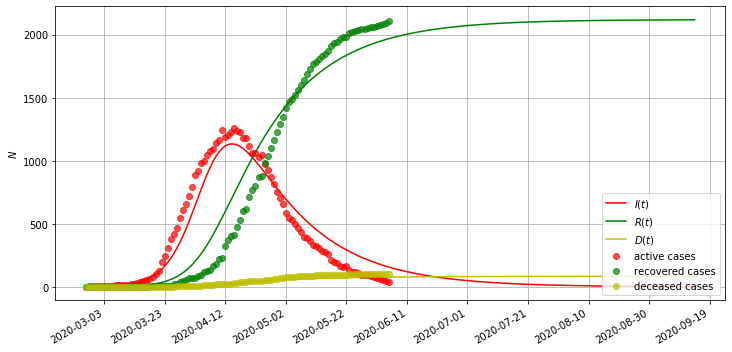

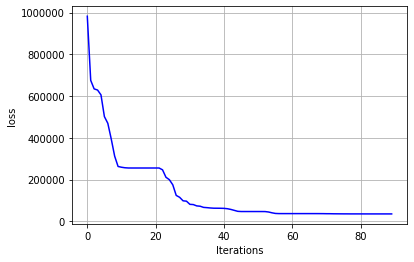

In [4]:
S0 = 2200
E0 = 3 * active_cases_1[0]
I0 = active_cases_1[0]
R0 = recovered_cases_1[0]
D0 = death_cases_1[0]

R_eff, loss = simulate_SEIRD(
    active_cases=active_cases_1, 
    recovered_cases=recovered_cases_1,
    death_cases=death_cases_1,
    initial_conditions=(S0, E0, I0, R0, D0),
    split_ratio=1.,
    epidemics_start_date=start_date_1,
)

plt.plot(loss, 'b-')
plt.xlabel('Iterations')
plt.ylabel('loss')
plt.grid()
plt.show()